In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
from tqdm import tqdm
import gym
%matplotlib inline

## 0. Start environment.

In [2]:
env = gym.make("CartPole-v0")

if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

print("Total actions and dim: {} act. , {} dim.".format(n_actions, state_dim))

Total actions and dim: 2 act. , (4,) dim.


In [3]:
model = nn.Sequential(
    nn.Linear(state_dim[0], 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, n_actions)
)

In [4]:
import torch.nn.functional as F

def predict_probs(states):
    with torch.no_grad():
        tens = torch.from_numpy(states).type(torch.float32)
        return F.softmax(model(tens)).cpu().numpy()

## 1. Define basic functions.

In [5]:
def generate_session(env, t_max=1000):
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        action_probs = predict_probs(np.array([s]))[0]

        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

def get_cumulative_rewards(
    rewards,  # rewards at each step
    gamma=0.99  # discount for reward
):
    T = len(rewards)
    G = np.zeros(T)
    G[-1] = rewards[-1]
    for i in range(T - 2, -1, -1):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G

def to_one_hot(y_tensor, ndims):
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

optimizer = torch.optim.Adam(model.parameters(), 1e-3)

def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)
    
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    entropy = torch.sum(probs*log_probs)
    loss = -(torch.mean(log_probs_for_actions * cumulative_returns) + entropy_coef * entropy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return np.sum(rewards)

## 2. Train process.

Iter = 22, mean reward: 638.4


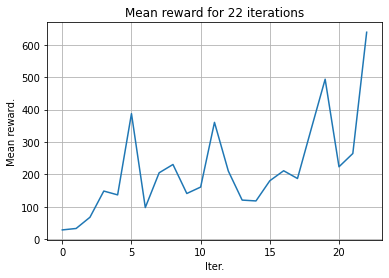

You Win!


In [6]:
rewards_hist = []

for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions
    
    clear_output(True)
    
    print("Iter = {}, mean reward: {}".format(i, round(np.mean(rewards), 3)))
    rewards_hist.append(np.mean(rewards))
    
    plt.grid()
    plt.plot(rewards_hist)
    plt.title("Mean reward for {} iterations".format(i))
    plt.xlabel("Iter.")
    plt.ylabel("Mean reward.")
    plt.show()
    
    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break